In [10]:
import os
import numpy as np
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Embedding, Input, Dropout, Flatten
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras import preprocessing
import matplotlib.pyplot as plt
from keras.datasets import reuters

## Aufgabe 1c

In [11]:
class RNNDATA(object):
    
    def __init__(self):
        """Initialize the data object"""
        self.window_size = 5
        self.input_dimension = 2* self.window_size +1
        self.embeddings_dim=50
                 
    def readFile(self, filename):
        """ read file
        return format : [[Word, Label]]
        [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ]"""
        f = open(filename)
        sentences = []
        
        sentence = []
        for line in f:
            splitLines = line.split()
            if len(splitLines) == 0:
                sentences.append(sentence)
                sentence = []
                
            else:
                sentence.append([splitLines[0].lower(),splitLines[3]])
        
        return sentences

    def loadData(self):
        """Load data"""
        self.trainSentences = self.readFile("./coNLL/eng.train")
        self.devSentences = self.readFile("./coNLL/eng.testa")
        self.testSentences = self.readFile("./coNLL/eng.testb")

    def extractWordsAndLabels(self):
        
        self.labels = set()
        self.words = {}

        print("Extracting words and labels...")
        for sentence in self.trainSentences:
            for token, label in sentence:
                self.labels.add(label)
                self.words[token.lower()] = True
        print(f"Extracted {len(self.words)} words and {len(self.labels)} labels.")
        # mapping for labels
        self.label2Idx = {}
        for label in self.labels:
            self.label2Idx[label] = len(self.label2Idx)
        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
                     


    def loadEmbeddings(self):
        """Create word-level embeddings"""
        
        self.wordEmbeddings = []
        self.word2Idx = {}
            
        
        # read GLoVE word embeddings
        fEmbeddings = open("./glove/glove.6B.50d.txt", encoding="utf-8")


        # loop through each word in the loaded embeddings
        # keep only the embeddings for words that appear in your data
        # make sure to lower case your words!
        
        self.word2Idx["PADDING_TOKEN"] = 0
        vector = np.zeros(self.embeddings_dim)
        self.wordEmbeddings.append(vector)

        self.word2Idx["UNKNOWN_TOKEN"] = 1
        vector = np.random.uniform(-0.25, 0.25, self.embeddings_dim)
        self.wordEmbeddings.append(vector)
        
        
        for line in fEmbeddings:
            splitLine = line.split()
            word = splitLine[0].lower()
            if word in self.words:
                vector = np.array([float(num) for num in splitLine[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                self.word2Idx[word] = len(self.word2Idx)  # corresponding word dict
        
        self.wordEmbeddings = np.array(self.wordEmbeddings)
        print(f"Found embeddings for {self.wordEmbeddings.shape[0]} of {len(self.words)} words.")
        
        
    # replace strings with ids (wordIDs and labelIDs) in the data
    # return format: [[wordIDs][label]]
    # [[4,7,2][0,0,1]]
    
    def createMatrices(self, sents):
        unknownIdx = self.word2Idx['UNKNOWN_TOKEN']

        sentences = []
           
        
        for sentence in sents:
            wordIdSentence = []
            labelIdSentence = []
            for token in sentence:
                if token[0] in self.word2Idx:
                    wordIdSentence.append(self.word2Idx[token[0]])
                else:
                    wordIdSentence.append(unknownIdx)
                
                labelIdSentence.append(self.label2Idx[token[1]])
            sentences.append([wordIdSentence, labelIdSentence])
    
        #print(sentences[:10])
        return sentences
    
    # returns samples of shape
    # [[wordIDs (1 + 2 * window size)]], [label]
    # [[0,0,4,6,2]] [0]
    # we want the label the center word of our window, that means padding for the first and last words in a sentence!
    
    def createSamples(self, sents):
        padding = self.word2Idx["PADDING_TOKEN"]
        x = []
        y = []
        print(sents[:10])
        for sentence in sents:
            words = sentence[0]
            labels = sentence[1]
            for i in range(len(words)):
                mid = self.window_size
                paddedWindow = [padding] *(1 + 2 * self.window_size)
                paddedWindow[mid] = words[i]
                for offset in range(self.window_size +1):
                    if i-offset >= 0:
                        paddedWindow[mid-offset] = words[i-offset]
                    if i+offset <len(words):
                        paddedWindow[mid+offset] = words[i+offset]
                x.append(paddedWindow)
                one_hot_encoding = np.zeros(len(self.label2Idx))
                one_hot_encoding[labels[i]] = 1;
                y.append(one_hot_encoding)
    
        return np.array(x),np.array(y)
    
    def prepareData(self):

        # format: [[wordindices],[labelindices]]
        self.trainset = self.createMatrices(self.trainSentences)
        self.valset = self.createMatrices(self.devSentences)
        self.testset = self.createMatrices(self.testSentences)

        # format: [[wordindices]],[labelindex]
        self.x_train, self.y_train = self.createSamples(self.trainset)
        self.x_val, self.y_val = self.createSamples(self.valset)
        self.x_test, self.y_test = self.createSamples(self.testset)

In [12]:
rnnData = RNNDATA()
rnnData.loadData()
print("Data loaded")
head = rnnData.trainSentences[:5]
print(head)

Data loaded
[[['-docstart-', 'O']], [['eu', 'I-ORG'], ['rejects', 'O'], ['german', 'I-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'I-MISC'], ['lamb', 'O'], ['.', 'O']], [['peter', 'I-PER'], ['blackburn', 'I-PER']], [['brussels', 'I-LOC'], ['1996-08-22', 'O']], [['the', 'O'], ['european', 'I-ORG'], ['commission', 'I-ORG'], ['said', 'O'], ['on', 'O'], ['thursday', 'O'], ['it', 'O'], ['disagreed', 'O'], ['with', 'O'], ['german', 'I-MISC'], ['advice', 'O'], ['to', 'O'], ['consumers', 'O'], ['to', 'O'], ['shun', 'O'], ['british', 'I-MISC'], ['lamb', 'O'], ['until', 'O'], ['scientists', 'O'], ['determine', 'O'], ['whether', 'O'], ['mad', 'O'], ['cow', 'O'], ['disease', 'O'], ['can', 'O'], ['be', 'O'], ['transmitted', 'O'], ['to', 'O'], ['sheep', 'O'], ['.', 'O']]]


In [13]:
rnnData.extractWordsAndLabels()
print("Dictionary Created")

Extracting words and labels...
Extracted 21010 words and 8 labels.
Dictionary Created


In [14]:
rnnData.loadEmbeddings()
print("Embeddings loaded")

Found embeddings for 18417 of 21010 words.
Embeddings loaded


In [15]:
rnnData.prepareData()

[[[1], [5]], [[639, 6304, 511, 577, 6, 4762, 295, 7641, 4], [4, 5, 2, 5, 5, 5, 2, 5, 5]], [[1273, 7084], [1, 1]], [[3648, 1], [7, 5]], [[2, 289, 622, 18, 15, 183, 22, 7736, 19, 511, 3093, 6, 1989, 6, 10238, 295, 7641, 206, 2103, 2321, 399, 4654, 5612, 1268, 86, 30, 6312, 6, 6181, 4], [5, 4, 4, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]], [[506, 11, 1998, 6, 2, 289, 352, 11, 8344, 443, 8972, 1, 18, 15, 176, 1989, 188, 972, 1, 27, 250, 68, 73, 689, 206, 2, 2369, 3093, 17, 9204, 4], [7, 5, 5, 5, 5, 4, 4, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5]], [[10, 53, 88, 70, 278, 129, 124, 6028, 112, 53, 88, 70, 251, 129, 3053, 12, 22, 3, 10, 2, 622, 11, 274, 389, 14012, 1433, 4580, 9866, 153, 9, 171, 4860, 4], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 1, 1, 1, 1, 5, 5, 5, 5, 5]], [[20, 18, 486, 2369, 795, 17, 1361, 7, 83, 22, 17, 236, 14, 603, 17, 898, 22, 188, 30, 489, 23, 2, 289, 352, 4], [5, 5, 5,

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Input, Dropout, Bidirectional, Flatten
from keras.optimizers import SGD, Nadam
from keras.metrics import Precision, Recall

In [112]:
class RNN(object):
    
    def __init__(self, DATA):
        """Initialize the model"""
        self.epochs = 10 #EPOCHS
        self.batch_size = 128
        self.dropout = 0.5 #DROPOUT
        self.data = DATA
        self.optimizer = Nadam()
        self.input_dimension = DATA.input_dimension
        self.lstm_state_size = 200
        
  
    def buildModel(self):
        """Build the model"""
        # Build a Sequential() model with the layers you need; add dropout if you want.
        
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.data.wordEmbeddings.shape[0], output_dim=self.data.wordEmbeddings.shape[1], weights=[self.data.wordEmbeddings],
                          trainable=False)(words_input)
 
        output = LSTM(self.lstm_state_size, dropout=self.dropout)(words)
        output = Dense(len(self.data.label2Idx), activation='softmax')(output)    
    
        self.model = Model(inputs=[words_input], outputs=[output])
        
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc', Precision(), Recall()])
        
        
        #Plot the network architecture
        plot_model(self.model, to_file='model.png')
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Train the model"""
       
        self.model.summary()
        self.model.history = self.model.fit(self.data.x_train, self.data.y_train,  validation_split=0.2, epochs=self.epochs, batch_size=self.batch_size)
        
        
        print("Training finished.")
        # (optional) save model to file if you don't want to train from scratch everytime
        self.modelName = "{}_{}_{}".format(self.epochs, self.data.window_size, self.dropout)
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        

    def plotTraining(self):
        """Plot graphs"""
        # Load the training statistics (model.history)
        # Plot training/validation loss and accuracy
        
        history = self.model.history.history
        print(history.keys())
        
        plt.plot(history["loss"], 'bo', label='Training loss')
        plt.plot(history["val_loss"], 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        plt.clf()

        
        plt.plot( history["acc"], 'bo', label='Training acc')
        plt.plot( history["val_acc"], 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    
            
    def predictLabel(self, x_testset, y_testset):
        """Tag unseen data with numerical values (label IDs)"""
        correctLabels = []
        predLabels = []
        for y in y_testset:
            for i in range(len(y)):
                if y[i]:
                    correctLabels.append(i)
        prediction = self.model.predict(x_testset)
       
        for p in prediction:  
            max = 0;
            maxIndex = 0;
            for i in range(len(p)):
                if p[i] >= max:
                    max = p[i]
                    maxIndex = i
            predLabels.append(maxIndex)
                
        return np.array(predLabels), np.array(correctLabels)
        
    def evaluate(self):
        """Test the model"""
        # Predict labels for the test data
        predictions, ground_truth = self.predictLabel(self.data.x_test, self.data.y_test)
        # Compare to gold standard/ground truth
        # First on token level, i.e. for each individual word
        # Print Precision, Recall, and F1 for all labels not O
        
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        all_non_O = 0
        for i in range(len(ground_truth)):
            if ground_truth[i] != self.data.label2Idx["O"]:
                all_non_O +=1
            if predictions[i] == ground_truth[i] and ground_truth[i] != self.data.label2Idx["O"]:
                tp+=1
            elif predictions[i] == ground_truth[i] and ground_truth[i] == self.data.label2Idx["O"]:
                tn+=1
            elif predictions[i] != ground_truth[i] and ground_truth[i] != self.data.label2Idx["O"]:
                fn+=1
            elif predictions[i] != ground_truth[i] and ground_truth[i] != self.data.label2Idx["O"]:
                fp+=1
        print("true positives ", tp, "false negatives ", fn, "true negative", tn, "false negative", fn)
        
        recall = tp / all_non_O
        precision = tp / (tp + fp)
        f1_score = (2 * tp) / (2 * tp + fp + fn)
        print(f": Precision {precision}, Recall {recall}, F1 Score {f1_score}")
        
        '''for label in self.data.label2Idx.values():
            print(label)
            indices_in_class =[]
            for i in range(len(ground_truth)):
                if ground_truth[i] == label: 
                    indices_in_class.append(i)
            print(indices_in_class)
            true_positives = (ground_truth[indices_in_class] == predictions[indices_in_class]).sum().item()
            false_negatives = len(indices_in_class) - true_positives
            
            recall = true_positives / len(indices_in_class)
            
            indices_predicted_in_class =[]
            for i in range(len(predictions)):
                if predictions[i] == label: 
                    indices_in_class.append(i)
            print(indices_predicted_in_class)        
            false_positives = (ground_truth[indices_predicted_in_class] != predictions[indices_predicted_in_class]).sum().item()

            precision = true_positives / (true_positives + false_positives)

            f1_score = (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)

            print(f"{idx2Label[label]}: Precision {precision}, Recall {recall}, F1 Score {f1_score}")
        '''
        
        # Output confusion matrix predicted label vs. true label token level
       
    
        # YOUR CODE HERE
        
        
        # Second on entity level, i.e. for each (multi-word) entity. E.g. ...New York... is only correctly labeled if both "New" and "York" were labeled as I-LOC (or B-LOC I-LOC) 
        # Print Precision, Recall, and F1 for all labels not O
        
        
        # YOUR CODE HERE
        
        
        # Output confusion matrix predicted label vs. true label entity level
        
        
        # YOUR CODE HERE
        

    print("Class initialised.")

Class initialised.


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model built. Saved model.png

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     [(None, None)]            0         
_________________________________________________________________
embedding_41 (Embedding)     (None, None, 50)          920850    
_________________________________________________________________
lstm_41 (LSTM)               (None, 200)               200800    
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 1608      
Total params: 1,123,258
Trainable params: 202,408
Non-trainable params: 920,850
_________________________________________________________________
Epoch 1/10
1279/1279 [==============================] - 29s 22ms

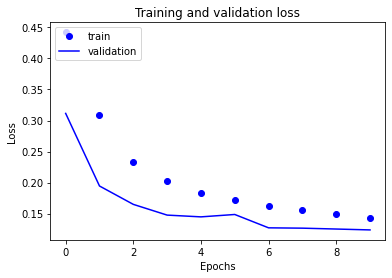

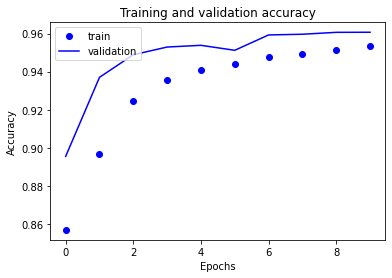

In [113]:
"""Construct and run model"""
rnn = RNN(rnnData)
rnn.buildModel()
rnn.train()
rnn.plotTraining()


In [114]:
rnn.evaluate()

true positives  6353 false negatives  1759 true negative 37854 false negative 1759
: Precision 1.0, Recall 0.7831607495069034, F1 Score 0.8783961285862426
